In [56]:
import random
import math
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cuda


In [57]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [58]:
class DQN:
  # initialize values
  def __init__(self, N, env):
    # initialize environment
    self.env = env
    state, info = self.env.reset()
    # initialize replay memory to capacity N
    self.pointer = 0
    self.policy_net = Net(len(state), self.env.action_space.n).to(device)
    self.target_net = Net(len(state), self.env.action_space.n).to(device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.optimizer = optim.AdamW(self.policy_net.parameters(),amsgrad=True ) #auto learning rate
    # big replay memory:
    self.size = N
    self.state_mem = torch.zeros((N, self.env.observation_space.shape[0]), dtype=torch.float32, device=device)
    self.next_state_mem = torch.zeros((self.size, self.env.observation_space.shape[0]), dtype=torch.float32, device=device)
    self.action_mem = torch.zeros(self.size, dtype=torch.int64, device=device)
    self.reward_mem = torch.zeros(self.size, dtype=torch.float32, device=device)
    self.done_mem = torch.zeros(self.size, dtype=torch.float32, device=device)
    self.pointer = 0

  def append(self, state, action, reward, next_state, done):
    i = self.pointer % self.size #get index
    self.state_mem[i] = state
    self.next_state_mem[i] = next_state
    self.reward_mem[i] = reward 
    self.done_mem[i] = 1 - int(done)
    self.action_mem[i] = action
    self.pointer +=1
    
  def sample(self,batch):
    mem = min(self.pointer,self.size) # get range to choose mem from
    batch = np.random.choice(mem,batch) # choose random indices
    states = self.state_mem[batch]
    next_states = self.next_state_mem[batch]
    actions = self.action_mem[batch]
    rewards = self.reward_mem[batch]
    done = self.done_mem[batch]
    return states, actions, rewards, next_states, done




  
  # Main training function
  def train(self, episodes, epsilon, discount, action_function, greedy):
    sum = 0
    total_reward = [0] * episodes  
    # TAU = .0004
    for i in range(episodes):
      
      self.target_net.load_state_dict(self.policy_net.state_dict())
      # initialize sequence S and preprocessed sequence o
      seq  = [None , None]
      state, info = self.env.reset()
      seq[0] = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      done = False
      rewards = 0
      eps = epsilon ** i if not greedy else 0
      if i%2==0:
         self.target_net.load_state_dict(self.policy_net.state_dict())
      while not done:
        # Select action
        action_type = action_function(seq[0], eps)
        observation, reward, terminated, truncated, _ = self.env.step(action_type.item())
        rewards += reward
        state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
        seq[1] = state
        # if terminated == False:
        #   reward = 100*((math.sin(3*seq[1][0,0])*0.0025+0.05*seq[1][0,1]*seq[1][0,1])-(math.sin(3*seq[0][0,0])*0.0025+0.5*seq[0][0,1]*seq[0][0,1]))
        # print(reward)
        # Set sequence
        self.append(state=seq[0], action=action_type, reward=reward, next_state=seq[1], done=terminated)
        if terminated:
           seq[1] = None
        # store transition in replay buffer
        seq[0] = state
        self.r(discount)
        done = truncated or terminated
      # Decay epsilon after every episode
      # epsilon *= epsilon
      total_reward[i] = rewards  
      if rewards >-110:
         sum +=0
      else:
         sum = 0
      if sum>10:
         break
    return total_reward

      
  def action(self, state, epsilon):
    if np.random.rand() < epsilon:
        action_type = self.env.action_space.sample()
    else:
        # select max(Q)
        with torch.no_grad():
            return self.policy_net(state).max(1).indices.view(1, 1) 
    return torch.tensor([[action_type]], device=device, dtype=torch.long)
        
  def r(self,discount):
      BATCH_SIZE = 256
      if self.pointer < BATCH_SIZE:
          return
      # Sample a batch from replay memory
      states, actions, rewards, next_states, dones = self.sample(BATCH_SIZE)
      
      # Convert to tensors
      state_batch = torch.tensor(states, dtype=torch.float32, device=device)
      action_batch = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
      reward_batch = torch.tensor(rewards, dtype=torch.float32, device=device)
      next_state_batch = torch.tensor(next_states, dtype=torch.float32, device=device)
      done_mask = torch.tensor(dones, dtype=torch.float32, device=device) # zeros out terminated
      
      # Calculate state-action values
      state_action_values = self.policy_net(state_batch).gather(1, action_batch)
      
      # Calculate next state values
      next_state_values = torch.zeros(BATCH_SIZE, device=device)
      with torch.no_grad():
          next_state_values[done_mask.bool()] = self.target_net(next_state_batch[done_mask.bool()]).max(1).values
      
      # Expected Q values
      expected_state_action_values = (next_state_values * discount) + reward_batch
      
      # Compute loss
      criterion = nn.SmoothL1Loss()
      loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
      
      # Optimize the model
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  
  # Save the current weights
  def save(self, filename):
    with open(filename, 'wb') as file:
      pickle.dump(self.policy_net.state_dict(), file,protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
#Prints the reward per epsisode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - int(min(reward_per_episode)) * (.15)
    maxs = int(max(reward_per_episode)) + int(max(reward_per_episode)) * (.3) 
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()


C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_batch = torch.tensor(states, dtype=torch.float32, device=device)
C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_batch = torch.tensor(rewards, dtype=torch.f

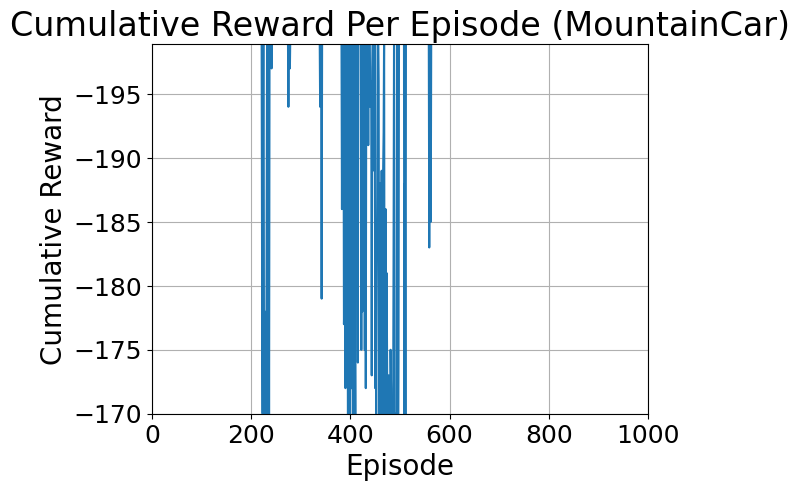

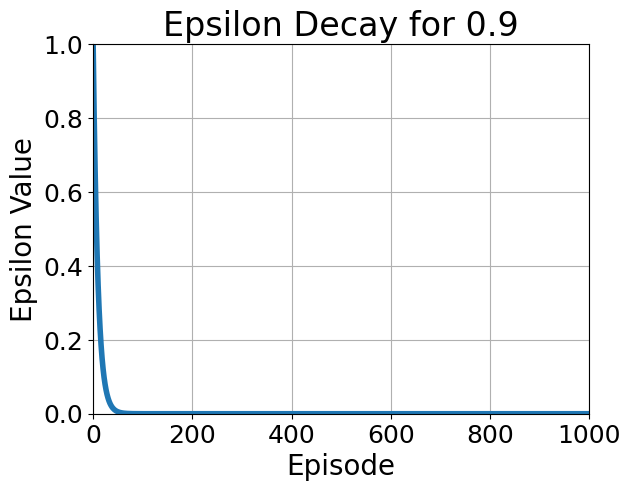

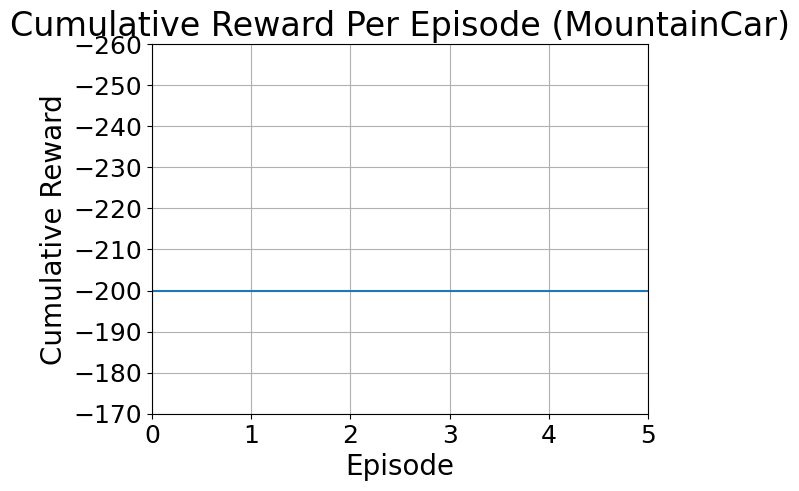

In [ ]:

N = 20000
env = gym.make("MountainCar-v0")
env.reset()
MtnCar = DQN(N, env)

episodes = 1000
epsilon = .9
discount = .99
action = MtnCar.action
total_rewards = MtnCar.train(episodes, epsilon, discount, action, False)
# MtnCar.save("drpreisl_angustsa_assignment2_part2_dqn_mountaincar.pickle")
reward_print(total_rewards, episodes, "MountainCar")
ep_decay(epsilon, episodes)
total_rewards = MtnCar.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "MountainCar")

C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_batch = torch.tensor(states, dtype=torch.float32, device=device)
C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
C:\Users\corvi\AppData\Local\Temp\ipykernel_9160\320647809.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_batch = torch.tensor(rewards, dtype=torch.f

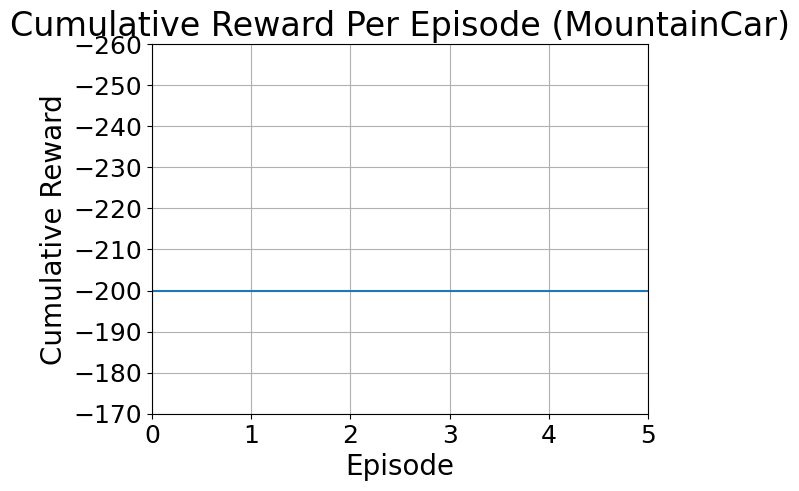

[-200.0, -200.0, -200.0, -200.0, -200.0, -200.0]


In [61]:
# MtnCar.save("drpreisl_angustsa_assignment2_part2_dqn_mountaincar.pickle")
total_rewards = MtnCar.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "MountainCar")
print(total_rewards)

In [62]:
# N = 5000
# env = gym.make("CartPole-v1")
# env.reset()
# cart = DQN(N, env)

# episodes = 600
# epsilon = .8
# discount = .99
# action = cart.mountain_car_action
# total_rewards = cart.train(episodes, epsilon, discount, action, False)
# # cart.save("drpreisl_angustsa_assignment2_part2_dqn_cartpole.pickle")
# reward_print(total_rewards, episodes, "CartPole")
# ep_decay(epsilon, episodes)
# total_rewards = cart.train(6, epsilon, discount, action, True)
# reward_print(total_rewards, 5, "CartPole")